In [1]:
cd ..

/home/sam/cc-net


/home/sam/anaconda3/envs/primal-dual/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import torch
import scipy.sparse as sp
from scipy.sparse import coo_matrix, triu

import yaml
import models.models as Models
import losses.losses as Losses
import datasets.datasets as Datasets

from tqdm.notebook import tqdm

In [3]:
def plot_graph(X, edge_index, ax):
    for i, j in zip(edge_index[0], edge_index[1]):
        ax.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color='0.8', alpha=0.8, zorder=1) 
    ax.scatter(X[:, 0], X[:, 1], edgecolors='none', color='red', zorder=2)

In [4]:
def visualize_clusters(X, U, ax, point_size=8, label="Clustered data"):
    """Plot the loss curve and a grayscale scatter of the smoothed solution U."""
    fig = plt.figure(figsize=(10,4))
    ax.scatter(X[:, 0], X[:, 1], s=8, edgecolors='none', alpha=0.5, label='original data')
    ax.scatter(U[:,0].cpu(), U[:,1].cpu(), s=point_size, alpha=0.9, c='0.4', label=label)

In [5]:
def load_model(model_cfg, model_pth):
    model_class = getattr(Models, model_config['model'])
    model = model_class(**model_config['cfg'])
    model = model.float()
    model_state = torch.load(model_pth, map_location='cpu')
    model.load_state_dict(model_state)
    return model

def forward_pass(model, data):
    src = data.edge_index[0]
    dst = data.edge_index[1]
    e_init = data.x[src] - data.x[dst]
    h, e = model(h=data.x.float(),
                 e=e_init.float(), 
                 edge_index = data.edge_index, 
                 w=data.edge_attr,
                 x=data.x.float())
    return h.detach(), e.detach()
    
def get_primal_obj(U, data, lam):
    src = data.edge_index[0]
    dst = data.edge_index[1]
    w = data.edge_attr
    X = data.x
    return Losses.energy(U, X, src, dst, w, lam)

In [6]:
exp_file = 'configs/sweeps/change-depth-two-moons.yaml'
with open(exp_file, "r") as f:
    exp_cfg = yaml.safe_load(f)

In [10]:
import wandb
api = wandb.Api()

entity_name = "primal-dual"
project_name = "primal-dual"
sweep_id = "xpmphfp5"

sweep_path = f"{entity_name}/{project_name}/sweeps/{sweep_id}"

try:
    sweep = api.sweep(sweep_path)
except Exception as e:
    print(f"Error fetching sweep: {e}")


In [12]:
all_runs = sweep.runs

print(f"Found {len(all_runs)} runs in sweep {sweep_id}")

# 6. Iterate through the runs to access data
for run in all_runs:
    print(f"Run ID: {run.id}")
    print(f"Config: {run.config}")

Found 10 runs in sweep xpmphfp5
Run ID: g1wu92pg
Config: {'lr': 0.0001, 'lam': 1, 'tau': 0.35, 'sigma': 0.35, 'epochs': 1000, 'batch_size': 12, 'hidden_dim': 128, 'num_layers': 10, 'model_config': {'cfg': {'lam': 1, 'in_edge_dim': 2, 'in_node_dim': 2, 'embedding_dim': 32, 'processor_cfg': {'cfg': {'tau': 0.35, 'sigma': 0.35, 'hidden_dim': 128, 'layer_type': 'PDHGLayer', 'num_layers': 10}, 'model': 'GraphPDHGNet'}, 'mlp_hidden_dim': 128, 'recurrent_steps': 1, 'residual_stream': False}, 'model': 'EncodeProcessDecode'}, 'learning_rate': 0.0001, 'loss_function': 'energy_pdg'}
Run ID: x4h3g5l1
Config: {'lr': 0.0001, 'lam': 1, 'tau': 0.35, 'sigma': 0.35, 'epochs': 1000, 'batch_size': 12, 'hidden_dim': 128, 'num_layers': 9, 'model_config': {'cfg': {'lam': 1, 'in_edge_dim': 2, 'in_node_dim': 2, 'embedding_dim': 32, 'processor_cfg': {'cfg': {'tau': 0.35, 'sigma': 0.35, 'hidden_dim': 128, 'layer_type': 'PDHGLayer', 'num_layers': 9}, 'model': 'GraphPDHGNet'}, 'mlp_hidden_dim': 128, 'recurrent_ste

In [8]:
print(exp_cfg['experiment'])

# Adjust experiment configs 


{'dataset': {'type': 'gaussian_blob_dataset', 'params': {'n_graphs': 300, 'min_n_nodes': 100, 'max_n_nodes': 200, 'n_clusters': 6, 'k_neighbors': 10, 'feature_dim': 2}, 'validation': {'use_train': True}}, 'model_config': {'model': 'EncodeProcessDecode', 'cfg': {'processor_cfg': {'model': 'GraphPDHGNet', 'cfg': {'layer_type': 'PDHGLayer', 'hidden_dim': 128, 'num_layers': 8, 'tau': 0.35, 'sigma': 0.35}}, 'in_node_dim': 2, 'in_edge_dim': 2, 'embedding_dim': 32, 'mlp_hidden_dim': 128, 'lam': 1.0, 'residual_stream': False, 'recurrent_steps': 1}}, 'device': 'cuda:5', 'epochs': 1000, 'loss_function': 'energy_pdg', 'lr': 0.0001, 'batch_size': 12}


In [56]:
exp_file = 'configs/single-runs/pdhg-knn-gaussian.yaml'
with open(exp_file, "r") as f:
    exp_cfg = yaml.safe_load(f)
model_config = exp_cfg['model_config']
model_pth = '/data/sam/primal-dual/energy_pdg/multiple_knn/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L1_H128_inN32_inE32_lam1.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/qhfvxd2r/final.pt'
model_pth = '/data/sam/primal-dual/energy_pdg/gaussian_blob_dataset/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L8_H128_inN32_inE32_lam1.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/tu2tnbun/final.pt'


In [57]:
model = load_model(model_config, model_pth)

In [58]:
# Load dataset
datapth = '/data/sam/primal-dual/data/gaussian_blob_dataset_n_graphs=1_min_n_nodes=100_max_n_nodes=200_n_clusters=6_k_neighbors=10_feature_dim=2-train.pt'
dataset = torch.load(datapth)

In [70]:
h, e = forward_pass(model, dataset[0])
nn_primal_obj = get_primal_obj(h, dataset[0], lam=1.0)
print(nn_primal_obj)

tensor(224.7814, dtype=torch.float64)


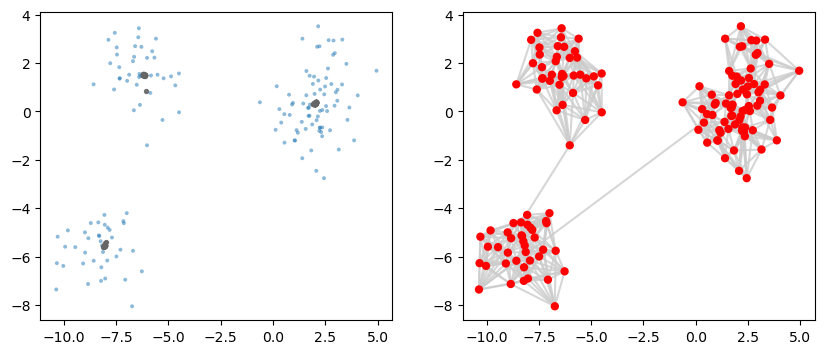

<Figure size 1000x400 with 0 Axes>

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
visualize_clusters(dataset[0].x, h, axs[0])
plot_graph(dataset[0].x,dataset[0].edge_index, axs[1])

In [61]:
## Load baseline algorithm results
pdhg_result = torch.load('/data/sam/primal-dual/baselines/gaussian_blob_dataset_n_graphs=1_min_n_nodes=100_max_n_nodes=200_n_clusters=6_k_neighbors=10_feature_dim=2-val_lam=1.0/output-C8dZ7iWweW9mRxDhTG9KFX.pt')

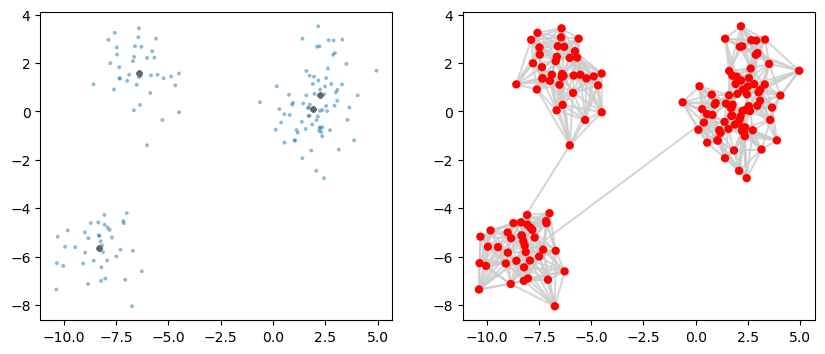

<Figure size 1000x400 with 0 Axes>

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
visualize_clusters(dataset[0].x, pdhg_result['U'][0], axs[0])
plot_graph(dataset[0].x,dataset[0].edge_index, axs[1])

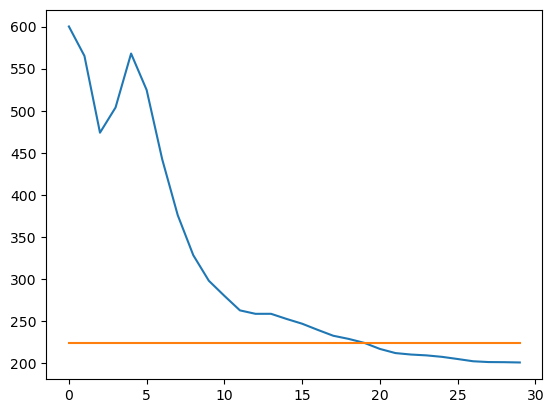

In [72]:
primal_objectives = pdhg_result['primal_objs'][0][:30]
line = np.ones(30)*224
plt.plot(np.arange(len(primal_objectives)), primal_objectives)
plt.plot(np.arange(len(primal_objectives)), line)
